# Lesson 1 - What's your pet

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_143.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_99.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_113.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_83.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_167.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

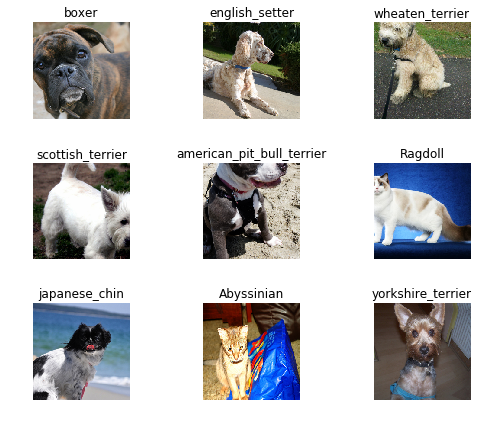

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.model

In [43]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.375049,0.357379,0.102842,01:43
1,0.555369,0.281245,0.085250,01:43
2,0.335782,0.256887,0.079161,01:44
3,0.251344,0.241389,0.073748,01:44


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

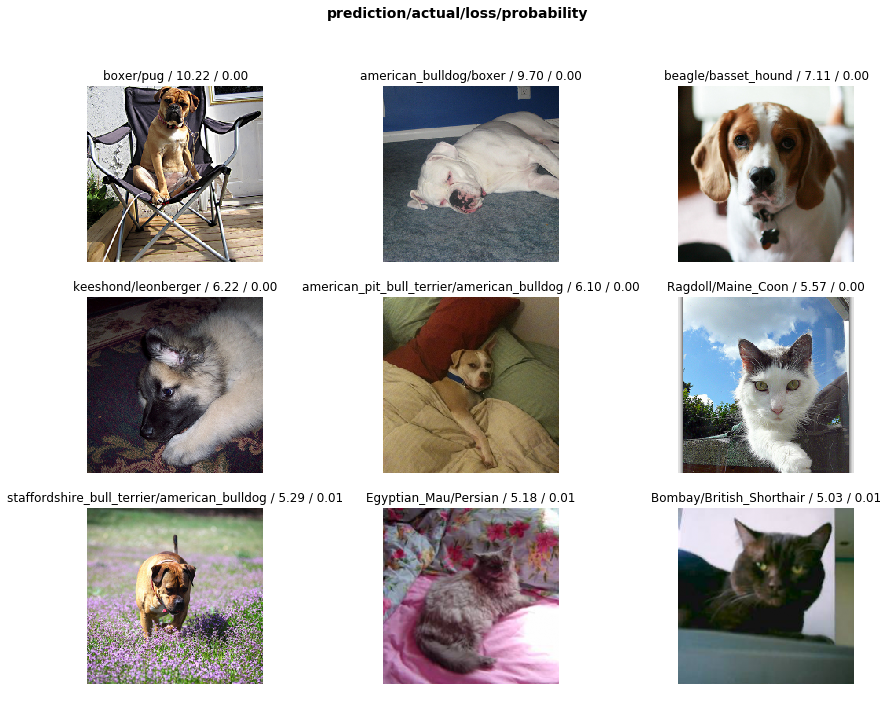

In [46]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

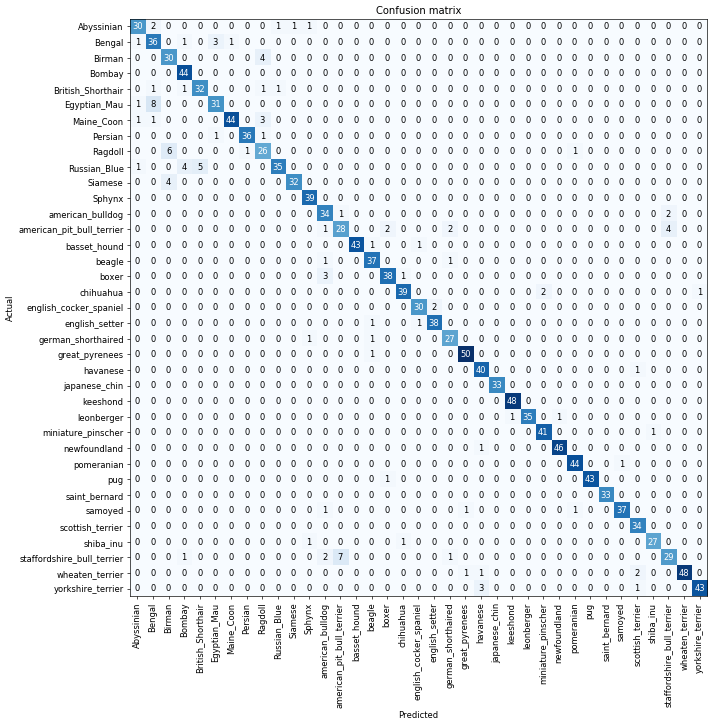

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [47]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('Ragdoll', 'Birman', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('Siamese', 'Birman', 4),
 ('Maine_Coon', 'Bengal', 3),
 ('Russian_Blue', 'Bombay', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('British_Shorthair', 'Ragdoll', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('boxer', 'american_bulldog', 2),
 ('samoyed', 'pomeranian', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

Unfreeze the model to train all of it instead of just training the final few layers.

In [0]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.506231,0.356542,0.121786,01:51


That didn't work so well. Let's reload the saved stage

In [0]:
learn.load('stage-1')

Learn learning rate finder.

What is the fastest I can train this neural net? (More next week)


In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


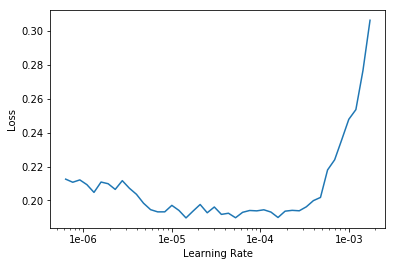

In [53]:
learn.recorder.plot()

Looks like loss keeps getting higher at the higher learning rate. (What does this mean?)

Anyway lets unfreeze and set the max learning rate range to something between 1e-06 and 1e-04 since that's the areas of lowest loss.

This means: "Train the very first layers at a learning rate of 1e-6, and the very last years at 1e-4, and kinda distribute the layers across that spectrum."


In [54]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.208565,0.227356,0.072395,01:49
1,0.183342,0.225000,0.071042,01:50


Great! We were able to get a bit of improvement from the original first training by fine tuning it.

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [56]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),
 ('Egyptian_Mau', 'Bengal', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('Siamese', 'Birman', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Abyssinian', 'Sphynx', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Abyssinian', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('samoyed', 'pomeranian', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

At this point, it seems like most of these breeds are very similar looking.

## Resnet 50

In [57]:
learn50 = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 31690098.61it/s]


In [59]:
learn50.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.858721,0.320517,0.093369,02:13
1,0.416041,0.313295,0.094723,02:05
2,0.252431,0.229392,0.075101,02:05
3,0.161139,0.216351,0.066982,02:05


In [0]:
learn50.save('stage-1-50')

In [61]:
interp = ClassificationInterpretation.from_learner(learn50)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [62]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Ragdoll', 'Birman', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Birman', 'Ragdoll', 3),
 ('Egyptian_Mau', 'Abyssinian', 3),
 ('Maine_Coon', 'Bengal', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('basset_hound', 'beagle', 3),
 ('boxer', 'american_bulldog', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('english_cocker_spaniel', 'english_setter', 2)]

In [63]:
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


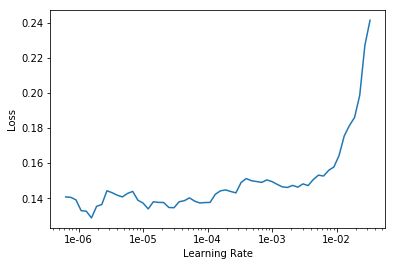

In [64]:
learn50.recorder.plot()

In [69]:
learn50.load('stage-1-50')
learn50.unfreeze()
learn50.fit_one_cycle(2, max_lr=slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.142599,0.212062,0.071042,02:25
1,0.129224,0.213194,0.066306,02:24


In [0]:
interp = ClassificationInterpretation.from_learner(learn50)

In [71]:
losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [72]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('basset_hound', 'beagle', 3),
 ('boxer', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Abyssinian', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Siamese', 'Birman', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_setter', 'english_cocker_spaniel', 2)]

In [0]:
download_url("https://cdn3-www.dogtime.com/assets/uploads/gallery/german-shepherd-dog-breed-pictures/standing-7.jpg", dest=path/"random_dog.jpg", overwrite=True) 

In [169]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/test'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/random_dog.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
random_dog = open_image(path/"random_dog.jpg")

In [0]:
tfms_dog = random_dog.apply_tfms(tfms=get_transforms()[0])

In [174]:
learn50.predict(tfms_dog)

(Category leonberger,
 tensor(25),
 tensor([2.1706e-03, 1.7267e-04, 3.0480e-05, 3.9261e-05, 4.7914e-06, 1.9277e-05,
         5.0807e-05, 5.5691e-06, 2.9618e-05, 3.0532e-05, 1.2160e-03, 4.2963e-06,
         9.1332e-06, 1.4411e-04, 1.5300e-04, 6.9150e-06, 6.1261e-05, 5.8217e-05,
         2.2856e-05, 3.1072e-05, 1.5564e-04, 4.8733e-05, 7.3659e-06, 9.8186e-06,
         4.9127e-03, 9.6822e-01, 1.3868e-04, 3.5222e-05, 6.1668e-06, 8.8551e-05,
         2.1268e-04, 3.8702e-05, 6.8503e-05, 2.1086e-02, 2.0577e-04, 2.6508e-04,
         2.4382e-04]))

Why does this model suck?